(5337.066429311364, [0])
Optimal objective -0.8413823533581086
Solution [[-0.12625287]
 [-0.03439816]
 [-0.00683972]
 [ 0.02635613]
 [ 0.06721869]
 [-0.27844915]
 [ 0.07433496]
 [ 0.13833929]
 [ 0.08421335]
 [ 0.03882609]]


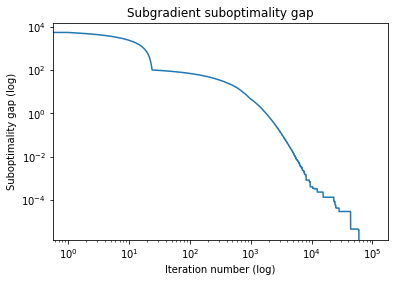

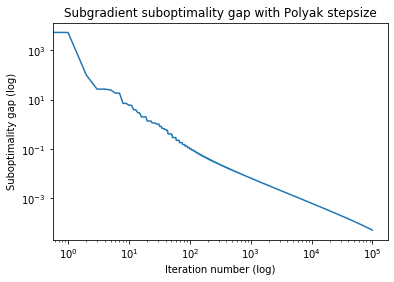

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n = 10

def A_ijk(i_input, j_input, k):
    if i_input != j_input:
        i = min(i_input, j_input)
        j = max(i_input, j_input)
        res = np.exp(i/j)*np.cos(i*j)*np.sin(k)
    else:
        term = 0
        for j_temp in range(1,n+1):
            if j_temp != i_input:
                i = min(i_input, j_temp)
                j = max(i_input, j_temp)
                term += np.abs(np.exp(i/j)*np.cos(i*j)*np.sin(k))
        res = i_input/10*np.abs(np.sin(k)) + term
    return res

def b_ik(i,k):
    return np.exp(i/k)*np.sin(i*k)

A_k = []
b_k = []
for k in range(1, 6):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            A[i, j] = A_ijk(i+1, j+1, k)
    A_k.append(A)
    b = np.zeros((n, 1))
    for i in range(n):
        b[i] = b_ik(i+1, k)
    b_k.append(b)

def MAXQUAD(x):
    vals = []
    for k in range(5):
        vals.append(x.T@A_k[k]@x - b_k[k].T@x)
    max_val = max(vals)
    ks = []
    for k in range(len(vals)):
        if abs(vals[k] - max_val) < 10e-6:
            ks.append(k)
    return max_val[0][0], ks

def get_subgrads(x, ks):
    subgrads = []
    for k in ks:
        subgrad = 2*A_k[k]@x - b_k[k]
        subgrads.append(subgrad)
    return subgrads

def check_stop(subgrads, eps):
    for subgrad in subgrads:
        if np.linalg.norm(subgrad) < eps:
            return True
    return False

def SD(x1, eps, C, opt='', f_star=None, num_iter=100000):

    curr_best, ks = MAXQUAD(x1)
    x = x1
    x_best = x
    subgrads = get_subgrads(x, ks)

    t = 0
    subopt_gap = []
    while not check_stop(subgrads, eps):
        if t>num_iter:
            break
        if f_star is not None:
            subopt_gap.append(curr_best - f_star)
        t+=1
        f_x, ks = MAXQUAD(x)
        if f_x < curr_best:
            curr_best = f_x
            x_best = x
        gs = get_subgrads(x, ks)
        g = gs[0]
        g_normed = g / np.linalg.norm(g)
        if opt == 'Polyak':
            gamma = (f_x - f_star)/np.linalg.norm(g)
        else:
            gamma = C/np.sqrt(t)
        x = x - gamma*g_normed

    return curr_best, x_best, subopt_gap


if __name__ == '__main__':
    x = np.ones((n,1))
    print(MAXQUAD(x))
    f_star, x_star, _ = SD(x, 10e-6, 0.05)
    print("Optimal objective", f_star)
    print("Solution", x_star)
    _, _, subopt_gap_1 = SD(x, 10e-6, 0.05, f_star=f_star)
    plt.loglog(subopt_gap_1)
    plt.xlabel("Iteration number (log)")
    plt.ylabel("Suboptimality gap (log)")
    plt.title("Subgradient suboptimality gap")
    plt.show()
    _, _, subopt_gap_2 = SD(x, 10e-6, 0.05, f_star=f_star, opt="Polyak")
    plt.clf()
    plt.loglog(subopt_gap_2)
    plt.xlabel("Iteration number (log)")
    plt.ylabel("Suboptimality gap (log)")
    plt.title("Subgradient suboptimality gap with Polyak stepsize")
    plt.show()